### Importing required packages

In [2]:
!pip install --q classiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is t

In [ ]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences
authenticate()

### Defining the problem and requirements

Problem:

Create a well-detailed Python Jupyter notebook that explains your algorithm, including the code parts covered in class, and pictures/figures where relevant.

In [ ]:
size = 4  # Number of qubits required, log_2(16)
num_nodes = 16  # Number of nodes in the line for the quantum walk (number of outputs possible)

### C Operator

In [17]:
@qfunc
def prepare_minus(x: QBit):
  # Creating the |-> state
  X(x)
  H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
  # Diffuzer oracle
  aux ^= (x != 0)

@qfunc
def zero_diffuzer(x: QNum):
  # Implementing the zero diffuser
  aux = QNum('aux')
  allocate(1, aux)
  within_apply(compute = lambda: prepare_minus(aux),
            action = lambda: diffuzer_oracle)

def C_iteration(i:int, vertices: QNum, adjacent_vertices: QNum):
  # Building the coin operator C
  prob = [0] * num_nodes  # Initialize probability vector for 16 nodes

  if i == 0:
    # Move to the right when at nodes (no.0 -> no.1)
    prob[i + 1] = 1.0

  elif i == (num_nodes - 1):
    # Move to the left when at nodes (no.14 <- no.15)
    prob[i - 1] = 1.0

  else:
    # 50/50 probability of moving right or left at any other given node
    prob[i + 1] = 0.5
    prob[i - 1] = 0.5

  print(f"\nNode: {i}\nProbabilities: {prob}")

  control(ctrl = vertices == i,
          operand = lambda: within_apply(
            compute = lambda: inplace_prepare_state(probabilities = prob, bound = 0.01, target = adjacent_vertices),
            action = lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def C_operator(vertices: QNum, adjacent_vertices: QNum):
  # Applying the previously built C operator
  for i in range(num_nodes):
      C_iteration(i, vertices, adjacent_vertices)

### S Operator

In [15]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  # Checking adjacency of verticies
  res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
  # Swapping bit-wise between arrays x & y
  repeat(count= x.len, iteration= lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
  # Using the above two defined functions to swap adjacent verticies
  res = QNum("res")
  edge_oracle(res, vertices, adjacent_vertices)
  control(ctrl = (res == 1), operand = lambda: bitwise_swap(vertices, adjacent_vertices))

### Circuit creation & synthesis

In [13]:
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
  # Using all the above defined sub-functions in the main function of the quantum walk

  allocate(size, vertices)
  hadamard_transform(vertices)
  allocate(size, adjacent_vertices)

  # Applying the C & S operators
  C_operator(vertices, adjacent_vertices)
  S_operator(vertices, adjacent_vertices)

In [16]:
qmod = create_model(main) # Creating the quantum walk model
qprog = synthesize(qmod) # Synthesizing the model
show(qprog) # Showing the model

Node: 0
Probabilities: [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node: 1
Probabilities: [0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node: 2
Probabilities: [0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node: 3
Probabilities: [0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node: 4
Probabilities: [0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node: 5
Probabilities: [0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node: 6
Probabilities: [0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node: 7
Probabilities: [0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node: 8
Probabilities: [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node: 9
Probabilities: [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node: 10
Probabilities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node: 11
Probabilities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node: 12
Probabilities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node: 13
Pr

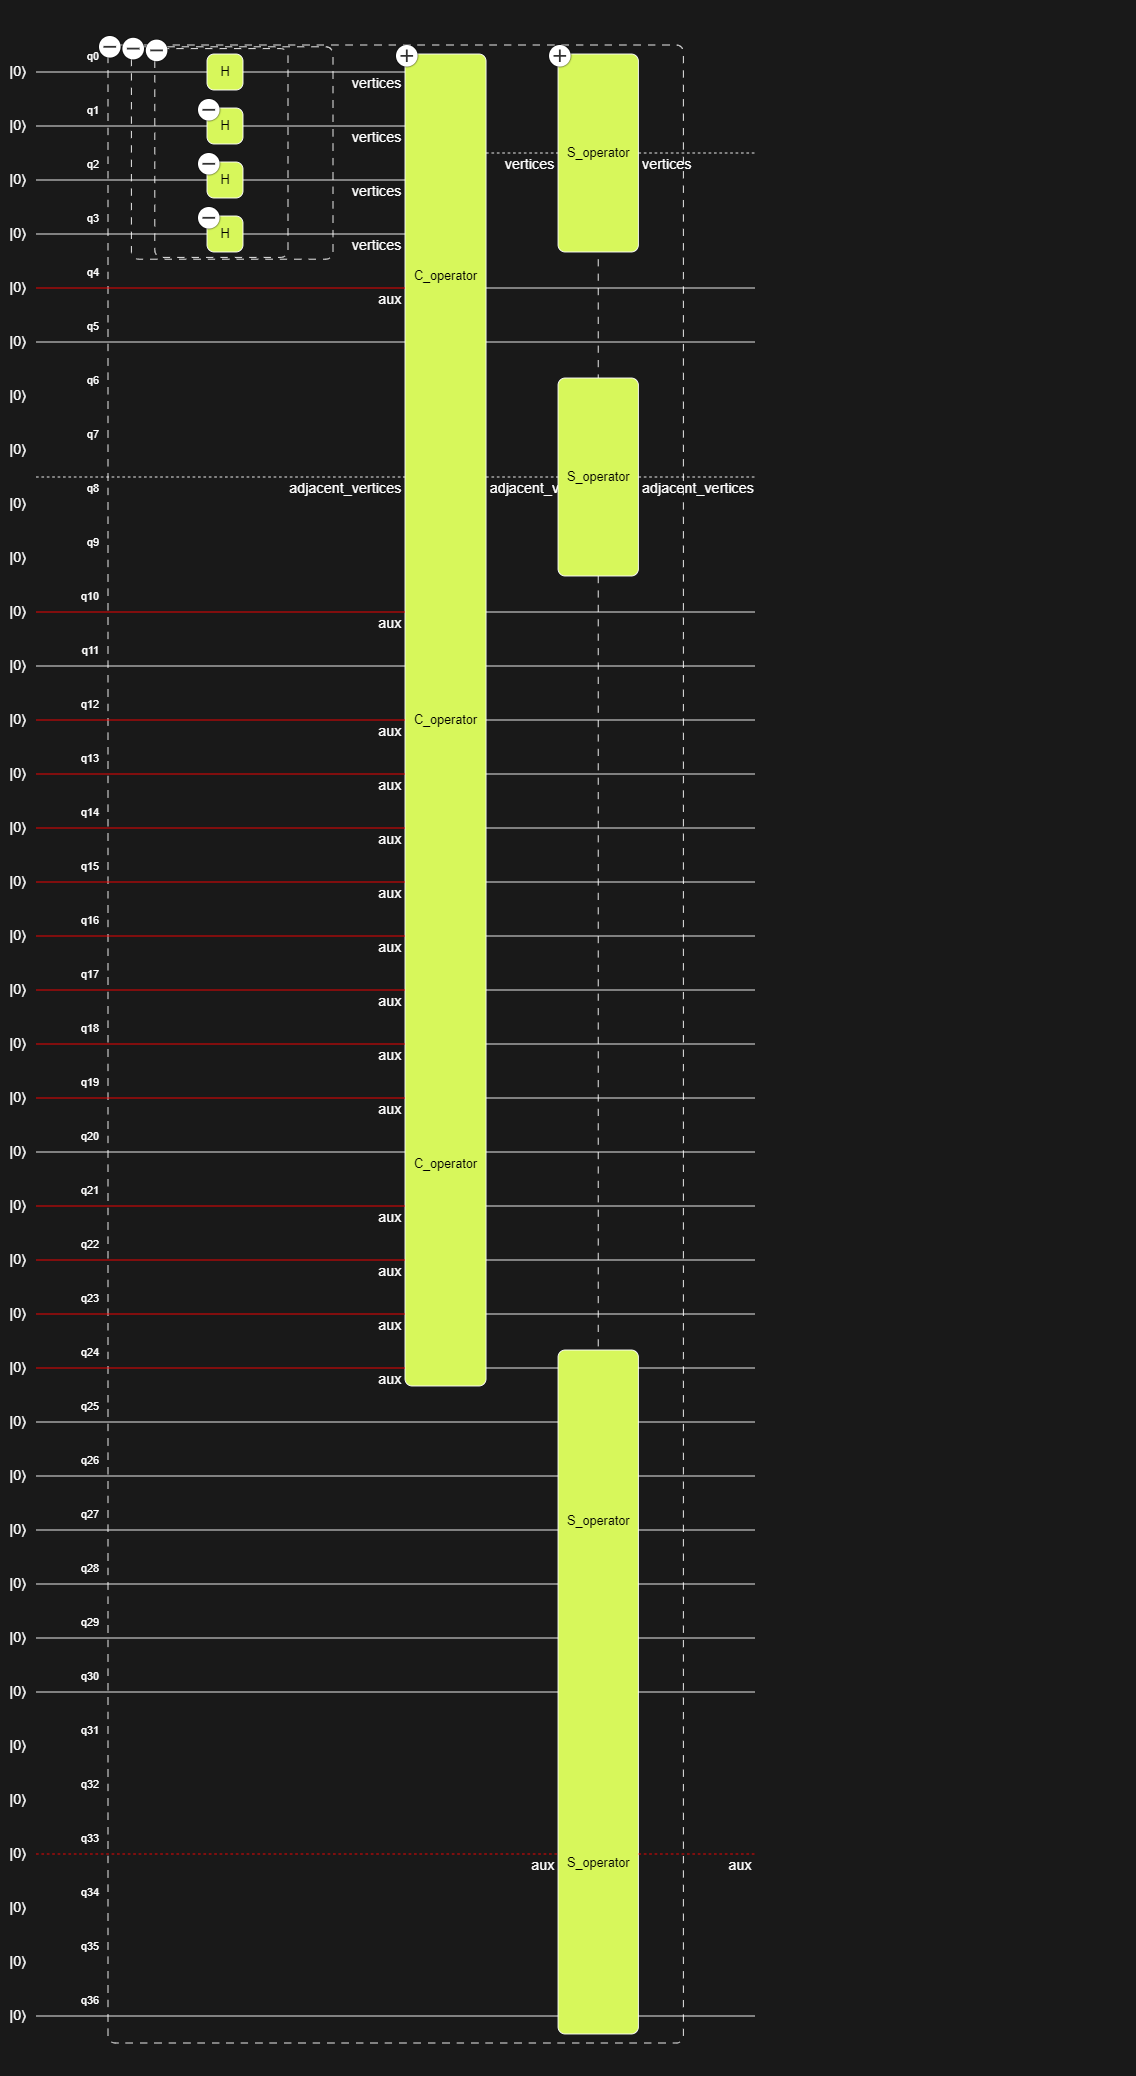